In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [3]:
categorical_features = [i for i in train_data.columns if train_data[i].dtype == 'object']
numeric_features = [i for i in train_data.columns if i not in categorical_features]

In [4]:
transformed = pd.get_dummies(train_data[categorical_features], drop_first=True).astype(int)
train_data.drop(categorical_features, axis=1, inplace=True)
train_data = pd.concat([train_data,transformed], axis=1)

transformed = pd.get_dummies(test_data[categorical_features], drop_first=True).astype(int)
test_data.drop(categorical_features, axis=1, inplace=True)
test_data = pd.concat([test_data,transformed], axis=1)

## Feature selection

<Axes: >

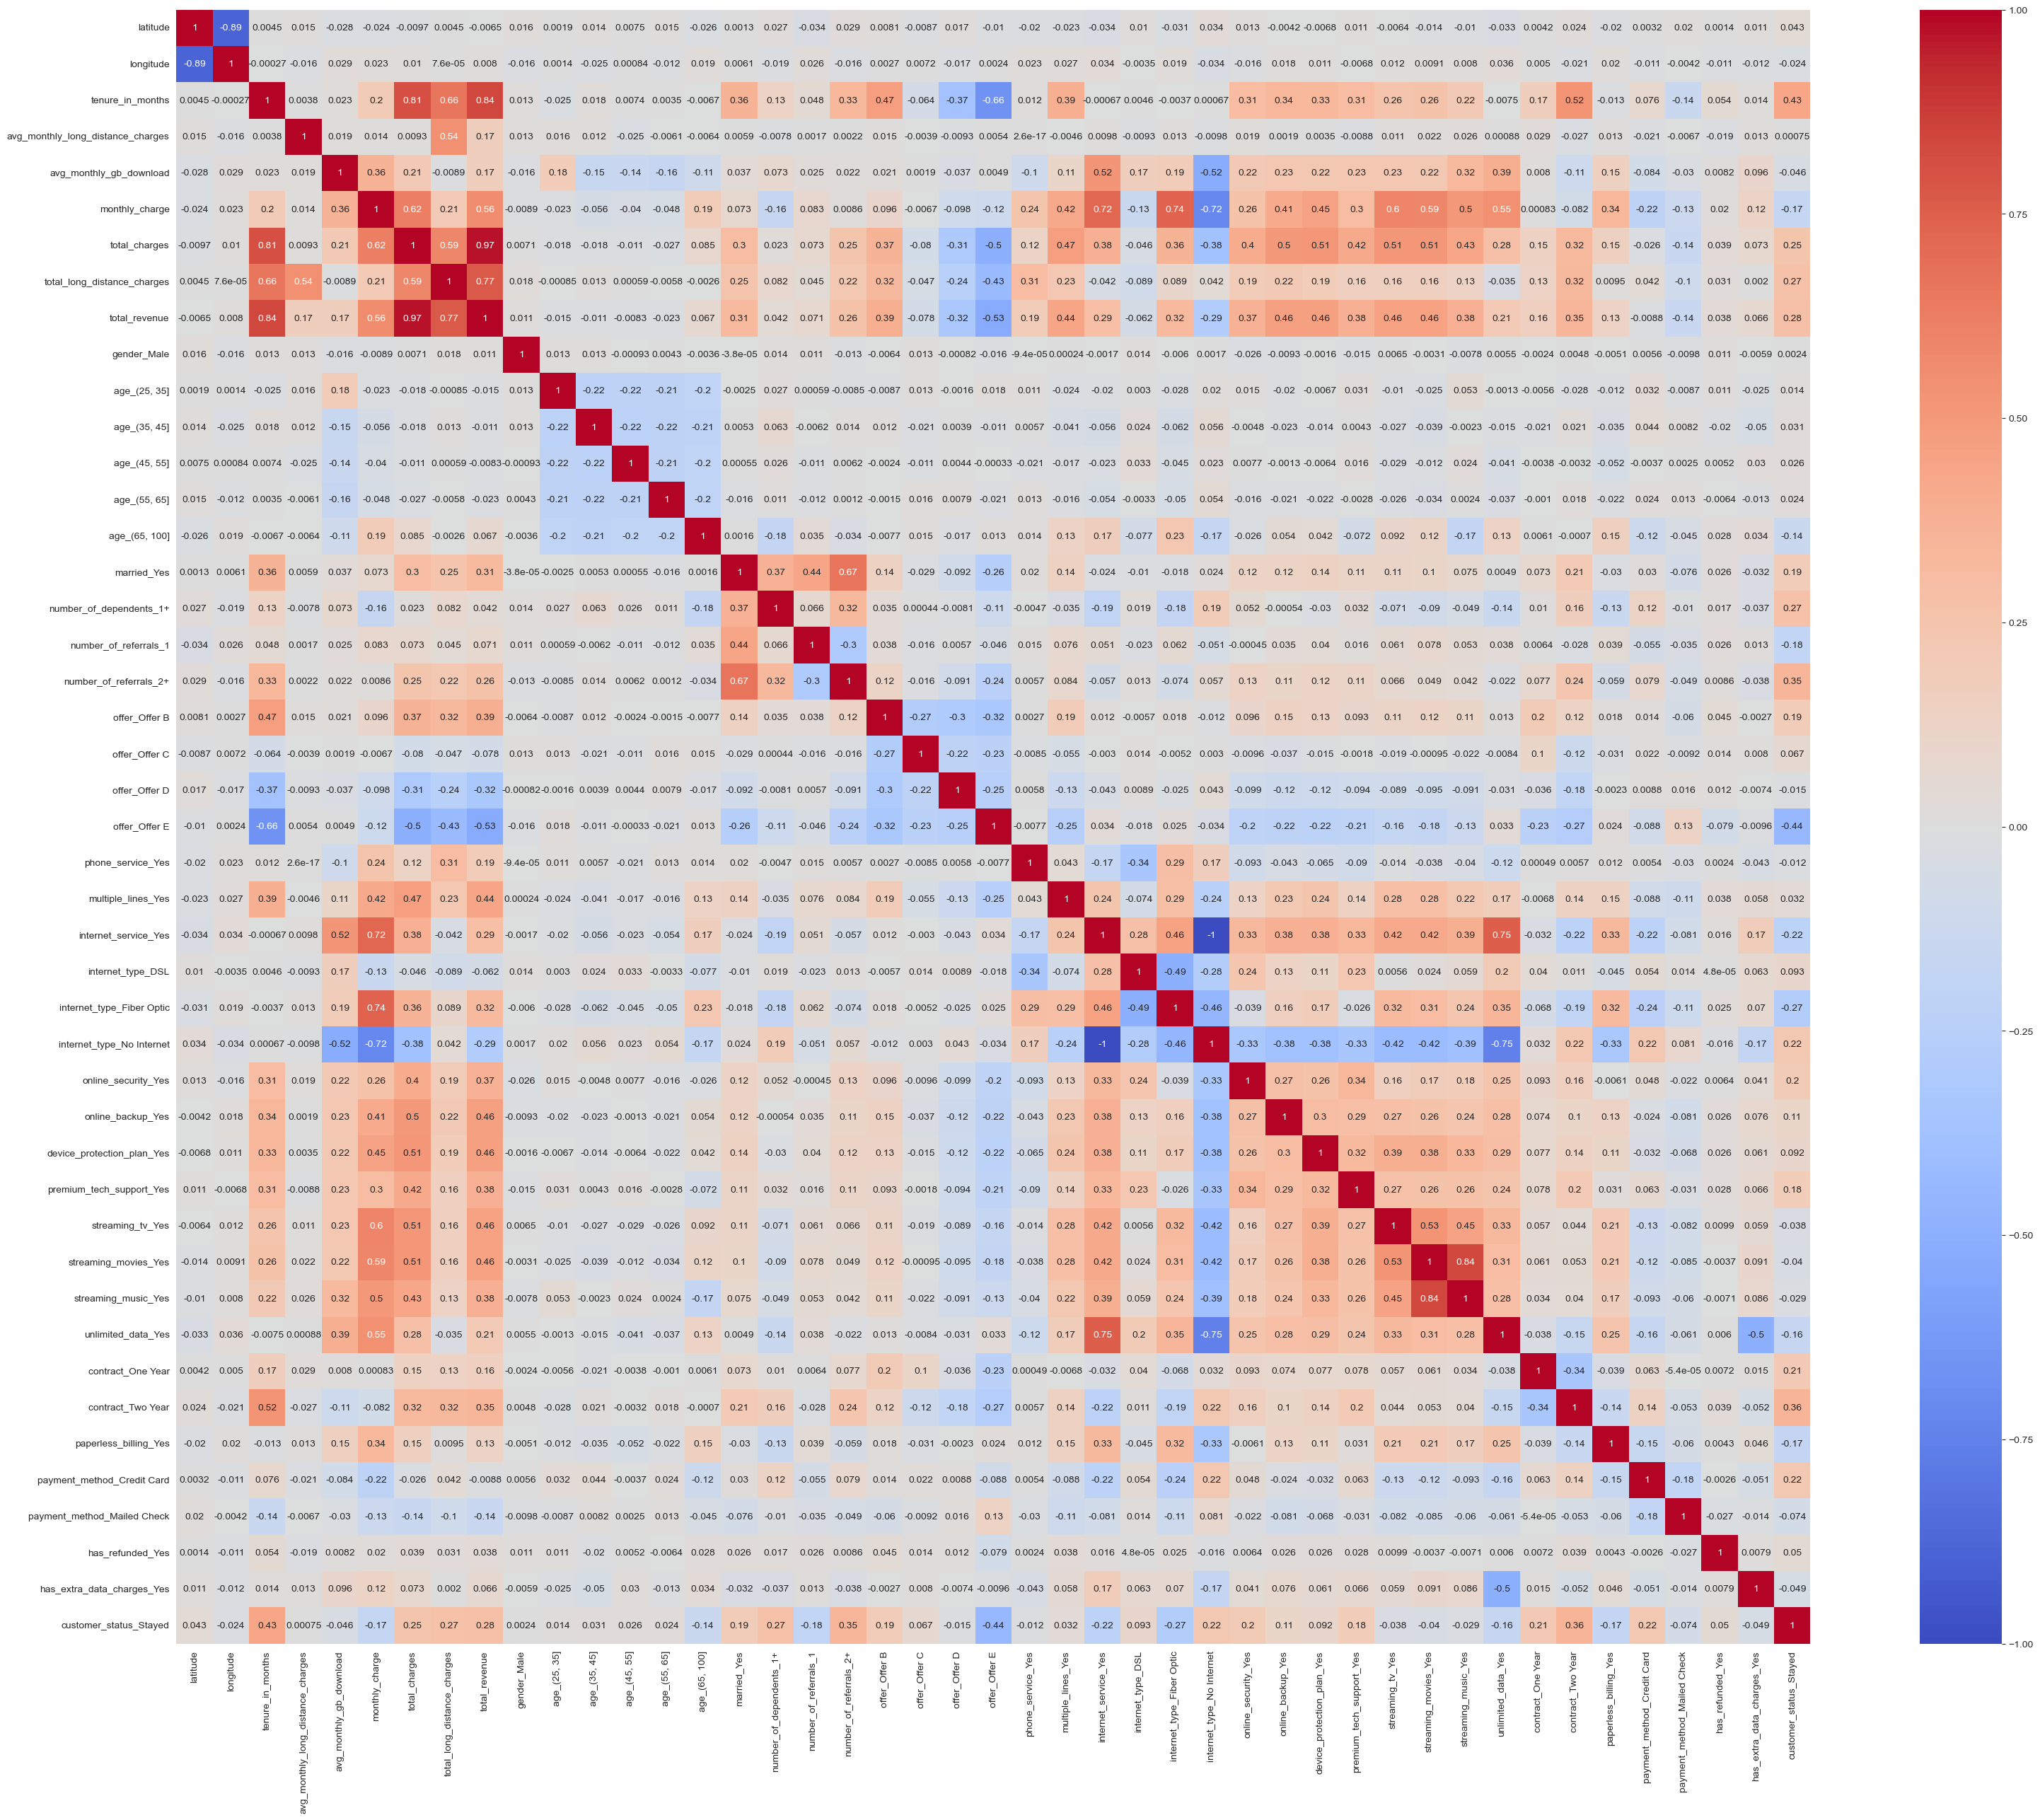

In [5]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

In [6]:
def select_to_drop(data):
    features = data.columns.drop('customer_status_Stayed')
    X = data.drop(columns=['customer_status_Stayed'])
    y = data['customer_status_Stayed']

    corr_matrix = data.corr()
    mask = abs(corr_matrix['customer_status_Stayed']) < 0.05
    corr_selected = corr_matrix['customer_status_Stayed'][mask].index

    selector = SelectKBest(f_classif, k=20)
    selector.fit_transform(X, y)
    k_selected = np.setdiff1d(features, selector.get_feature_names_out())

    mi = mutual_info_classif(X, y)
    mi_selected = features[np.where(mi < 0.01)]

    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
    rfe.fit(X, y)
    rfe_selected = np.setdiff1d(features, features[rfe.support_])

    intermediate1 = np.intersect1d(corr_selected, k_selected)
    intermediate2 = np.intersect1d(intermediate1, mi_selected)
    result = np.intersect1d(intermediate2, rfe_selected)

    return result

In [7]:
drop_features = select_to_drop(train_data)

In [8]:
drop_features

array(['age_(25, 35]', 'age_(35, 45]', 'age_(45, 55]', 'age_(55, 65]',
       'gender_Male', 'has_extra_data_charges_Yes', 'multiple_lines_Yes',
       'offer_Offer D', 'phone_service_Yes', 'streaming_movies_Yes',
       'streaming_music_Yes', 'streaming_tv_Yes'], dtype=object)

In [9]:
train_data.drop(drop_features, axis=1, inplace=True)
test_data.drop(drop_features, axis=1, inplace=True)

# Model Training

In [10]:
X_train = train_data.drop('customer_status_Stayed', axis=1)
y_train = train_data['customer_status_Stayed']

X_test = test_data.drop('customer_status_Stayed', axis=1)
y_test = test_data['customer_status_Stayed']

In [11]:
categorical_features = [i for i in X_train.columns if X_train[i].dtype in ['int32']]
numeric_features = [i for i in X_train.columns if i not in categorical_features]

## Logistic Regression

In [12]:
numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias=False))
    ])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_transform', numeric_transformer, numeric_features),
            ('passthrough', 'passthrough', categorical_features)
        ]
    )

param_grid = [
        {
            'logreg__penalty': ['l2', None],
            'logreg__C': [x for x in np.linspace(1, 5, 10)],
            'logreg__solver': ['lbfgs'],
            'preprocessor__num_transform__poly__degree': [1, 2, 3, 4]

        },
        {
            'logreg__penalty': ['l1', 'l2'],
            'logreg__C': [x for x in np.linspace(1, 5, 10)],
            'logreg__solver': ['liblinear'],
            'preprocessor__num_transform__poly__degree': [1, 2, 3, 4]
        },
        {
            'logreg__penalty': ['l1', 'l2', 'elasticnet', None],
            'logreg__C': [x for x in np.linspace(1, 5, 10)],
            'logreg__solver': ['saga'],
            'logreg__l1_ratio': [0.5, 0.7, 0.9],
            'preprocessor__num_transform__poly__degree': [1, 2, 3, 4]
        }
    ]

pipe = Pipeline([('preprocessor', preprocessor),
                 ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000))])
grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring=make_scorer(f1_score),
                    cv=10,
                    n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)
df = pd.DataFrame(grid.cv_results_)

In [23]:
df.sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__penalty,param_logreg__solver,param_preprocessor__num_transform__poly__degree,param_logreg__l1_ratio,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
106,20.056803,2.802125,0.023873,0.006240,2.333333,l1,liblinear,3,NaN,"{'logreg__C': 2.333333333333333, 'logreg__pena...",...,0.870588,0.891429,0.852601,0.872247,0.880707,0.893678,0.891089,0.877755,0.011935,1
98,17.842560,4.499254,0.020313,0.003402,1.888889,l1,liblinear,3,NaN,"{'logreg__C': 1.8888888888888888, 'logreg__pen...",...,0.872621,0.889843,0.854257,0.873529,0.880707,0.890490,0.890141,0.877556,0.010769,2
90,12.500670,2.197739,0.021100,0.002383,1.444444,l1,liblinear,3,NaN,"{'logreg__C': 1.4444444444444444, 'logreg__pen...",...,0.872993,0.889843,0.852601,0.871870,0.880707,0.893372,0.890141,0.876979,0.011769,3
86,3.197708,0.284115,0.029097,0.005339,1.0,l2,liblinear,3,NaN,"{'logreg__C': 1.0, 'logreg__penalty': 'l2', 'l...",...,0.869693,0.888252,0.853026,0.871870,0.879056,0.893678,0.888575,0.876649,0.011366,4
114,24.218364,4.713078,0.021755,0.002668,2.777778,l1,liblinear,3,NaN,"{'logreg__C': 2.7777777777777777, 'logreg__pen...",...,0.864307,0.889843,0.852601,0.872247,0.879056,0.892396,0.891089,0.876550,0.011970,5


In [14]:
model = grid.best_estimator_

In [15]:
pred = model.predict(X_test)
f1_score(y_test, pred)

0.880641925777332

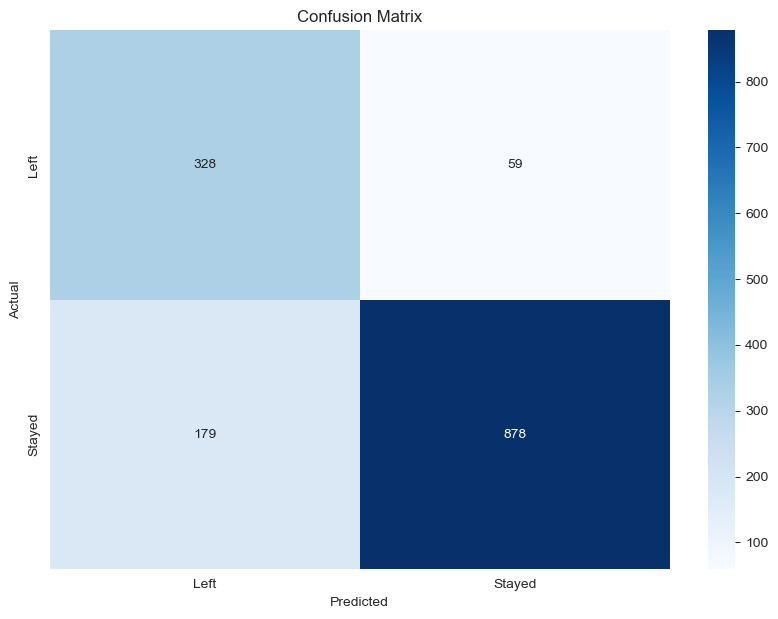

In [34]:
conf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Left', 'Stayed'], yticklabels=['Left', 'Stayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num_transform',
                                    Pipeline(steps=[('scaler', StandardScaler()),
                                                    ('poly',
                                                     PolynomialFeatures(degree=3,
                                                                        include_bias=False))]),
                                    ['latitude', 'longitude', 'tenure_in_months',
                                     'avg_monthly_long_distance_charges',
                                     'avg_monthly_gb_download', 'monthly_charge',
                                     'total_charges',
                                     'total_long_distance_charges',
                                     'total_revenue']),
                                   ('passthroug...
                                     'internet_service_Yes', 'internet_type_DSL',
                                